In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import os
import pandas as pd
%load_ext watermark

In [2]:
%watermark -v -p pandas,geopandas,shapely

CPython 3.6.2
IPython 6.1.0

pandas 0.20.2
geopandas 0.2.1
shapely 1.5.17.post1


## Read NERC regions shapefile

In [3]:
path = os.path.join('Data storage', 'NERC_Regions_EIA', 'NercRegions_201610.shp')
regions = gpd.read_file(path)

In [4]:
regions

,NERC,NERC_Label,geometry
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...
1,FRCC,Florida Reliability Coordinating Council (FRCC),(POLYGON ((-81.95506602699999 24.5196900770000...
2,MRO,Midwest Reliability Organization (MRO),POLYGON ((-95.07148604699995 49.36451082200006...
3,NPCC,Northeast Power Coordinating Council (NPCC),(POLYGON ((-73.82134384999995 40.6045004290000...
4,RFC,ReliabilityFirst Corporation (RFC),(POLYGON ((-90.89359863199996 29.0467829150000...
5,SERC,SERC Reliability Corporation (SERC),(POLYGON ((-91.71222639199999 32.9756623780000...
6,SPP,Southwest Power Pool (SPP),(POLYGON ((-93.73310749999996 30.4137588960000...
7,TRE,Texas Reliability Entity (TRE),POLYGON ((-100.0008629659999 35.02950123100004...
8,WECC,Western Electricity Coordinating Council (WECC),"(POLYGON ((-117.215183729 32.77737140300007, -..."


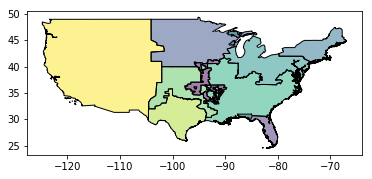

In [5]:
regions.plot()

## Read file with facility location, generation, and fuel data

In [6]:
path = os.path.join('Data storage', 'Facility gen fuels and CO2 2017-05-25.zip')
facility_df = pd.read_csv(path)

### Drop plants without lat/lon data
From 2001-present, 9 facilities (out of 8,414) don't have valid lat/lon data. All of them are from 2010 or earlier. Drop these rows or the spatial join fails. The amount of generation from these plants is tiny - well under 0.05% in all years.

In [18]:
print(len(facility_df['plant id'].unique()), 'total plants')
print(len(facility_df.loc[facility_df['lat'].isnull(), 'plant id'].unique()),
      'plants without lat/lon')

8414 total plants
9 plants without lat/lon


In [16]:
years = facility_df.loc[facility_df['lat'].isnull(), 'year'].unique()
for year in years:
    total_gen = facility_df.loc[facility_df['year'] == year, 'generation (MWh)'].sum()
    
    # Plant ids with no 'lat' in year
    no_loc_plants = facility_df.loc[(facility_df['lat'].isnull()) & 
                                    (facility_df['year'] == year), 'plant id'].unique()
    
    no_loc_gen = facility_df.loc[(facility_df['year'] == year) &
                                 (facility_df['plant id'].isin(no_loc_plants)),
                                  'generation (MWh)'].sum()
    
    percent_dropped = no_loc_gen / total_gen * 100
    
    print('In {}, {:.3f}% of generation is from plants without lat/lon'.format(year, percent_dropped))

In 2010, 0.000% of generation is from plants without lat/lon
In 2009, 0.000% of generation is from plants without lat/lon
In 2008, 0.000% of generation is from plants without lat/lon
In 2007, 0.000% of generation is from plants without lat/lon
In 2006, 0.000% of generation is from plants without lat/lon
In 2005, 0.001% of generation is from plants without lat/lon
In 2004, 0.001% of generation is from plants without lat/lon
In 2003, 0.011% of generation is from plants without lat/lon
In 2002, 0.024% of generation is from plants without lat/lon
In 2001, 0.031% of generation is from plants without lat/lon


In [19]:
facility_df.dropna(inplace=True, subset=['lat', 'lon'])

In [20]:
facility_df.columns

Index(['f', 'fuel', 'month', 'plant id', 'total fuel (mmbtu)', 'year',
       'generation (MWh)', 'elec fuel (mmbtu)', 'geography', 'last_updated',
       'lat', 'lon', 'prime mover', 'datetime', 'quarter',
       'all fuel fossil CO2 (kg)', 'elec fuel fossil CO2 (kg)',
       'all fuel total CO2 (kg)', 'elec fuel total CO2 (kg)'],
      dtype='object')

Because I have monthly data for every facility from 2001-2017, there are lots of duplicate rows. No need to do a spatial join on every row. Just keep one instance of each facility in each year.

In [21]:
cols = ['lat', 'lon', 'plant id', 'year']
small_facility = facility_df.loc[:, cols].drop_duplicates()

Use `Point` from Shapely to create the `geometry` list of facility locations. `crs` is the coordinate reference system that translates lat/lon into a specific map projection.

In [22]:
geometry = [Point(xy) for xy in zip(small_facility.lon, small_facility.lat)]
# small_facility = small_facility.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(small_facility, crs=crs, geometry=geometry)

In [23]:
geo_df.head()

,lat,lon,plant id,year,geometry
0,27.9114,-81.6006,10275,2017,POINT (-81.6006 27.9114)
3,27.9114,-81.6006,10275,2016,POINT (-81.6006 27.9114)
15,27.9114,-81.6006,10275,2015,POINT (-81.6006 27.9114)
27,27.9114,-81.6006,10275,2014,POINT (-81.6006 27.9114)
39,27.9114,-81.6006,10275,2013,POINT (-81.6006 27.9114)


In [24]:
len(geo_df)

100810

## Spatial join of NERC dataframe with polygons and facility dataframe with points
Joining the 9 regions (NERC) with 100,810 records takes much longer with facilities as the left dataframe in the join (2 min vs 12 seconds). Not quite sure why this is. The faster method leaves me with polygons rather than points tho. There might be a better way to rectify this, but I just create a new geodataframe with the geometry set as the lat/lon points.

**EDIT**
Although the GeoPandas documentation says that the `op` parameter doesn't matter for point-in-polygon operations, using 'within' made the operation much faster (12 seconds). The first method below is probably preferable since it keeps the point geometry.

**Method 1** (slow unless you use `op='within'`)

In [26]:
facility_nerc = gpd.sjoin(geo_df, regions, how='inner', op='within')

In [27]:
facility_nerc.head()

,lat,lon,plant id,year,geometry,index_right,NERC,NERC_Label
0,27.9114,-81.6006,10275,2017,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)
3,27.9114,-81.6006,10275,2016,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)
15,27.9114,-81.6006,10275,2015,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)
27,27.9114,-81.6006,10275,2014,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)
39,27.9114,-81.6006,10275,2013,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)


**Method 2** (faster when using the default operation)

In [10]:
facility_nerc = gpd.sjoin(df, geo_df, how="inner")

In [11]:
facility_nerc.head()

,NERC,NERC_Label,geometry,index_right,lat,lon,plant id,year
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200931,40.389167,-91.394167,57953,2014
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200919,40.389167,-91.394167,57953,2015
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200907,40.389167,-91.394167,57953,2016
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200904,40.389167,-91.394167,57953,2017
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1201030,40.389167,-91.394167,57953,2011


Make the new geometry of facility locations

In [12]:
geometry = [Point(xy) for xy in zip(facility_nerc.lon, facility_nerc.lat)]

Create new dataframe with the data I want to keep and the new geometry

In [13]:
crs = {'init': 'epsg:4326'}
keep_cols = ['NERC_Label', 'plant id', 'year']
facility_nerc = GeoDataFrame(facility_nerc[keep_cols], crs=crs, geometry=geometry)

In [14]:
facility_nerc.head()

,NERC_Label,plant id,year,geometry
0,Indeterminate - various NERC membership,57953,2014,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2015,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2016,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2017,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2011,POINT (-91.39416700000001 40.389167)


## Changing the crs to see what happens
Just making sure that it does something

In [31]:
df_test = df.to_crs({'init': 'epsg:3395'})

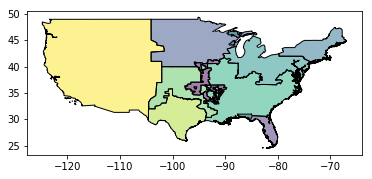

In [32]:
df.plot()

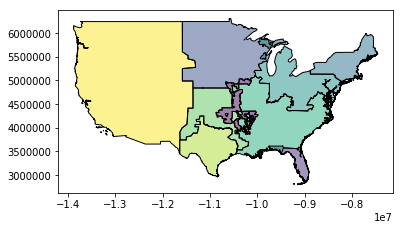

In [33]:
df_test.plot()